# Imports

In [1]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime

# Helper functions

In [2]:
conversion_rates = {
    'CHF': 1.14,  # 1 CHF = 1.134556 USD as of Feb 20, 2024, according to X-Rates
    'TRY': 0.032,   # 1 TRY = 0.03230 USD as of Feb 21, 2024, according to Wise
    'PLN': 0.25,  # 1 PLN = 0.250338 USD as of Feb 21, 2024, according to Xe.com
    'GBP': 1.26,      # Example rate, adjust with the actual rate when available
    'JOD': 1.41,      # Example rate, adjust with the actual rate when available
    'AUD' : 0.66,
    'BRL' : 0.2,
    'IDR' : 0.000064,
    'USD' : 1.0,
    'EUR' : 1.08,
    'ALL' : 0.010,
    'JPY' : 0.0066,
    'BDT' : 0.0091,
}



In [3]:
def convert_to_usd(row, price_col_name, currency_col_name):
    price = row[price_col_name]
    currency = row[currency_col_name]
    price = row['ticket_price']
    conversion_rate = conversion_rates.get(currency)

    # Check if conversion_rate is None
    if conversion_rate is None:
        # Handle the error (e.g., return 0, raise an exception, or use a default conversion rate)
        raise ValueError(f"Conversion rate for currency '{currency}' is not available.")
        # Alternatively, you can return 0 or some default value instead of raising an error
        # return 0
    
    return price * conversion_rate


In [4]:
def clean_fifth_element(lst):
    cleaned_lst = []
    for item in lst:
        if len(item) >= 5:
            fifth_element = item[4]
            if isinstance(fifth_element, int):
                cleaned_lst.append(fifth_element)
            else:
                try:
                    cleaned_lst.append(int(fifth_element))
                except ValueError:
                    # If the fifth element cannot be converted to an integer, replace it with 0
                    cleaned_lst.append(0)
        else:
            cleaned_lst.append(0)  # If the list is too short, consider the fifth element as 0
    return cleaned_lst



In [5]:
def convert_list_to_datetime(date_list):
    # Convert 'null' strings to 0 and other elements to integers
    date_list = [0 if element == 'null' else int(element) for element in date_list]
    
    try:
        if len(date_list) == 5:
            # If all components are present, unpack the list directly into datetime
            return datetime(*date_list)
        elif len(date_list) == 4:
            # If the minute is missing (or any single component), append 0 for minutes and then convert
            return datetime(*(date_list + [0]))
        else:
            # Return None for lists of unexpected length to indicate an issue
            return None
    except TypeError:
        # Handle cases where the list contents cannot be directly unpacked into datetime
        return None




In [6]:
def clean_fifth_element(lst):
    cleaned_lst = []
    for item in lst:
        if len(item) >= 5:
            fifth_element = item[4]
            if isinstance(fifth_element, int):
                cleaned_lst.append(item[:4] + [fifth_element] + item[5:])
            else:
                try:
                    cleaned_lst.append(item[:4] + [int(fifth_element)] + item[5:])
                except ValueError:
                    # If the fifth element cannot be converted to an integer, replace it with 0
                    cleaned_lst.append(item[:4] + [0] + item[5:])
        else:
            # If the list is too short, consider the fifth element as 0
            cleaned_lst.append(item[:4] + [0])
    return cleaned_lst



# Read and Clean Dataset

In [7]:
df = pd.read_csv('../data/3.raw_query_results/Query4_results_test.csv')

In [8]:
for i in ['arrival_date','departure_date']:
    df[i] = df[i].apply(ast.literal_eval)

In [9]:
df['arrival_date'] = clean_fifth_element(df['arrival_date'])
df['departure_date'] = clean_fifth_element(df['departure_date'])

In [10]:
for i in ['arrival_date','departure_date']:
    df[i] = df[i].apply(convert_list_to_datetime)

**Create identifier (FlightID) for identical flights**

In [11]:
df['Flight_ID'] = df[['airline_code', 'departure_airport_code', 'destination_airport_code','First_flight','last_flight_code','arrival_date','departure_date', 'departure_time','selling_airline','arrival_time','first_flight_code']].astype(str).agg('-'.join, axis=1)

In [12]:
df = df.drop(['departure_time','selling_airline','arrival_time'], axis = 1)

In [13]:
#df = df[df['Detected_Country'] != 'Shqipëri']


In [14]:
df.Detected_Country.value_counts()

Detected_Country
Polska                736
Schweiz               715
Indonesia             670
Türkiye               642
Deutschland           596
Australia             543
Shqipëri              536
Brasil                472
日本                    428
বাংলাদেশ              416
United Kingdom        358
Palestine             144
Vereinigte Staaten     84
Kıbrıs                 14
Name: count, dtype: int64

**Remove duplicates**

In [15]:
df["Duplicate_checker"] = df['Flight_ID'] + df['Detected_Country'] + df["Detected_Language"] + df["Detected_Country"] + str(df["ticket_price"])

In [16]:
df_reduced = df.drop_duplicates(subset='Duplicate_checker', keep='first').copy()

In [17]:
df_reduced = df_reduced.drop(['Duplicate_checker'], axis = 1)

**Remove NaN and erroneous rows**

In [18]:
df_reduced.dropna(subset=['Detected_Currency', 'ticket_price', 'Detected_Country'], inplace=True)

In [19]:
df_reduced = df_reduced[df_reduced['ticket_price'] >= 10]

# Feature engineering

In [20]:
df_reduced['Price_in_USD'] = df_reduced.apply(lambda row: convert_to_usd(row, 'ticket_price', 'Detected_Currency'), axis=1)

Creating commutime time

In [21]:
df_reduced['commute_time'] = (df_reduced['arrival_date'] - df_reduced['departure_date']).dt.total_seconds() / 60

In [22]:
df_reduced['query_date'] = pd.Timestamp('2024-02-15')

In [23]:
df_reduced['days_until_departure'] = (df_reduced['departure_date'] - df_reduced['query_date']).dt.days

**Eliminating queries with little country variance**

In [24]:
# Count the number of different countries available per Flight_ID
country_count_per_flight = df_reduced.groupby('Flight_ID')['Detected_Country'].nunique().reset_index(name='FlightID_in_Countries_Count')

# Merge this count back into the original dataframe
df_reduced = df_reduced.merge(country_count_per_flight, on='Flight_ID')


In [25]:
df_reduced = df_reduced[df_reduced['FlightID_in_Countries_Count'] >= 8]

**Creating Journey_ID: Identifier for identical journeys (same departure and destination airport) on same days**

Extracting departure and arrival days

In [26]:
df_reduced["departure_date_day"] = df_reduced["departure_date"].dt.strftime('%d-%m-%Y')
df_reduced["arrival_date_day"] = df_reduced["arrival_date"].dt.strftime('%d-%m-%Y')

Creating column for whole Journey

In [27]:
df_reduced["Journey_route"] = df_reduced["departure_airport_code"] + "-" + df_reduced["destination_airport_code"]

In [28]:
df_reduced["Journey_ID"] = df_reduced["Journey_route"] + ": " + df_reduced["departure_date_day"] + " "  + df_reduced["arrival_date_day"]

**Creating Variables that analyse price differences between identical Flights**

In [29]:
# Group by Flight_ID and calculate max, min prices and their absolute difference
price_stats = df_reduced.groupby('Flight_ID')['Price_in_USD'].agg(['max', 'min'])
price_stats['max_price_diff_FlightID'] = price_stats['max'] - price_stats['min']
price_stats.columns = ['max_price_FlightID', 'min_price_FlightID', 'max_price_diff_FlightID']
# Calculate the relative difference as a percentage of the min price
price_stats['max_rel_price_diff_FlightID'] = (price_stats['max_price_diff_FlightID'] / price_stats['min_price_FlightID']) * 100

In [30]:
df_reduced = pd.merge(df_reduced, price_stats, on='Flight_ID', how='left')

In [31]:
df_reduced["abs_diff_to_min_price_FlightID"] = df_reduced["Price_in_USD"] - df_reduced["min_price_FlightID"]
df_reduced["rel_diff_to_min_price_FlightID"] = ((df_reduced["Price_in_USD"] /df_reduced["min_price_FlightID"] ) -1) * 100
df_reduced['rel_price_score_FlightID'] = df_reduced['rel_diff_to_min_price_FlightID'] / df_reduced['max_rel_price_diff_FlightID']

**Creating Variables that analyse price differences between identical Journey**

In [32]:
# Group by Flight_ID and calculate max, min prices and their absolute difference
price_stats_journey = df_reduced.groupby('Journey_ID')['Price_in_USD'].agg(['max', 'min'])
price_stats_journey['max_abs_diff_JourneyID'] = price_stats_journey['max'] - price_stats_journey['min']
price_stats_journey.columns = ['max_price_JourneyID', 'min_price_JourneyID', 'max_abs_diff_JourneyID']
price_stats_journey['max_rel_diff_Journey'] = (price_stats_journey['max_abs_diff_JourneyID'] / price_stats_journey['min_price_JourneyID']) * 100

In [33]:
df_reduced = pd.merge(df_reduced, price_stats_journey, on='Journey_ID', how='left')

In [34]:
df_reduced["abs_diff_to_min_price_JourneyID"] = df_reduced["Price_in_USD"] - df_reduced["min_price_JourneyID"]
df_reduced["rel_diff_to_min_price_JourneyID"] = ((df_reduced["Price_in_USD"] /df_reduced["min_price_JourneyID"] ) -1) * 100
df_reduced['rel_price_score_JourneyID'] = df_reduced['rel_diff_to_min_price_JourneyID'] / df_reduced['max_rel_diff_Journey']

**Creating Variables that analyse price differences between identical Journey within the same query-country**

In [35]:
price_stats_journey_same_country = df_reduced.groupby(['Journey_ID', 'Detected_Country'])['Price_in_USD'].agg(['max', 'min'])
price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] = price_stats_journey_same_country['max'] - price_stats_journey_same_country['min']
price_stats_journey_same_country.columns = ['max_journey_same_country', 'min_journey_same_country', 'max_abs_diff_perIDGroup_Journey_same_country']
price_stats_journey_same_country['max_rel_diff_perIDGroup_Journey_same_country'] = (price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] / price_stats_journey_same_country['min_journey_same_country']) * 100

In [36]:
df_reduced = pd.merge(df_reduced, price_stats_journey_same_country, on=['Journey_ID','Detected_Country'], how='left')

In [37]:
df_reduced["price_diff_loc_to_glob_Journey_min"] = df_reduced["min_journey_same_country"] - df_reduced["min_price_JourneyID"]
df_reduced["rel_price_diff_loc_to_glob_Journey_min"] = (df_reduced["price_diff_loc_to_glob_Journey_min"] / df_reduced["min_price_JourneyID"]) * 100

In [38]:
# Group by 'Detected_Country' and calculate the mean of 'rel_price_diff_loc_to_glob_Journey_min'
grouped_means = df_reduced.groupby('Detected_Country')['rel_price_diff_loc_to_glob_Journey_min'].mean()

# Display the result
print(grouped_means)


Detected_Country
Australia              7.035948
Brasil                 3.084377
Deutschland            3.859205
Indonesia              3.959648
Palestine              4.120533
Polska                 3.835188
Schweiz                4.383528
Shqipëri               0.358481
Türkiye                3.597201
United Kingdom         7.392782
Vereinigte Staaten     4.479632
বাংলাদেশ               3.802642
日本                    17.559797
Name: rel_price_diff_loc_to_glob_Journey_min, dtype: float64


In [39]:
(price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] / price_stats_journey_same_country['min_journey_same_country']) * 100

Journey_ID                      Detected_Country
BWI-LUX: 26-02-2024 27-02-2024  Australia           10.514983
                                Brasil              10.526606
                                Deutschland         10.506067
                                Indonesia           10.525340
                                Polska              10.524152
                                                      ...    
ZAG-NRT: 05-11-2024 07-11-2024  Polska               0.000000
                                Schweiz              0.000000
                                Shqipëri             0.000000
                                Türkiye              0.000000
                                বাংলাদেশ             0.000000
Length: 565, dtype: float64

In [40]:

# Step 1: Filter to get rows where Price_in_USD equals the min for each Journey_ID
cheapest_mask_journey = df_reduced['Price_in_USD'] == df_reduced['min_price_JourneyID']
cheapest_journeys = df_reduced[cheapest_mask_journey]

# Group by Flight_ID and select the first Detected_Country name alphabetically
cheapest_locations_journey = cheapest_journeys.groupby('Journey_ID')['Detected_Country'].min().reset_index()

# Rename the column for clarity
cheapest_locations_journey.rename(columns={'Detected_Country': 'Cheapest_Location_Journey'}, inplace=True)

# Step 2: Merge this information back with the original DataFrame
df_reduced = df_reduced.merge(cheapest_locations_journey, on='Journey_ID', how='left')



In [41]:
df_reduced.Cheapest_Location_Journey.value_counts()

Cheapest_Location_Journey
Shqipëri          2054
Brasil             242
日本                 220
United Kingdom      10
Name: count, dtype: int64

In [42]:

# Step 1: Filter to get rows where Price_in_USD equals the min for each Flight_ID
cheapest_mask = df_reduced['Price_in_USD'] == df_reduced['min_price_FlightID']
cheapest_flights = df_reduced[cheapest_mask]

# Group by Flight_ID and select the first Detected_Country name alphabetically
cheapest_locations = cheapest_flights.groupby('Flight_ID')['Detected_Country'].min().reset_index()

# Rename the column for clarity
cheapest_locations.rename(columns={'Detected_Country': 'Cheapest_Location_Flight'}, inplace=True)

# Step 2: Merge this information back with the original DataFrame
df_reduced = df_reduced.merge(cheapest_locations, on='Flight_ID', how='left')

In [43]:
cheapest_flights = df_reduced[df_reduced['Price_in_USD'] == df_reduced['min_price_FlightID']]

In [44]:
unique_flight_ids = cheapest_flights['Flight_ID'].nunique()
total_rows = cheapest_flights.shape[0]

if unique_flight_ids == total_rows:
    print("Each min_price_FlightID identifies a unique row per Flight_ID.")
else:
    print(f"Some Flight_IDs have multiple rows with the same minimum price. Unique Flight IDs: {unique_flight_ids}, Total Rows: {total_rows}")


Each min_price_FlightID identifies a unique row per Flight_ID.


In [45]:
df_reduced.Cheapest_Location_Flight.value_counts()

Cheapest_Location_Flight
Shqipëri          2167
Brasil             259
日本                  90
United Kingdom      10
Name: count, dtype: int64

# Creating Main Variables for Prediction

In [46]:
# Calculate the average of rel_diff_to_min_price_FlightID for each Journey_ID and Detected_Country
average_savings_journeyID = df_reduced.groupby(['Journey_ID', 'Detected_Country'])['rel_diff_to_min_price_FlightID'].mean().reset_index(name='average_savings_for_JourneyID_in_Detected_Country')
# Merge the average_savings DataFrame back into df_reduced
df_reduced = df_reduced.merge(average_savings_journeyID, on=['Journey_ID', 'Detected_Country'], how='left')

In [47]:
# Calculate the average of rel_diff_to_min_price_FlightID for each Journey_ID and Detected_Country
average_savings_route = df_reduced.groupby(['Journey_route', 'Detected_Country'])['rel_diff_to_min_price_FlightID'].mean().reset_index(name='average_savings_for_Journey_route_in_Detected_Country')
# Merge the average_savings DataFrame back into df_reduced
df_reduced = df_reduced.merge(average_savings_route, on=['Journey_route', 'Detected_Country'], how='left')


In [48]:
average_savings_route.sort_values(by ='average_savings_for_Journey_route_in_Detected_Country', ascending=False)
with pd.option_context('display.max_rows', None):
    display(average_savings_route.sort_values(by='average_savings_for_Journey_route_in_Detected_Country', ascending=False))

Journey_route    Detected_Country  \
167       LAX-LIS           Australia   
174       LAX-LIS      United Kingdom   
176       LAX-LIS                  日本   
277       PHX-CGH           Australia   
285       PHX-CGH      United Kingdom   
214       MAN-CPT           Australia   
222       MAN-CPT      United Kingdom   
219       MAN-CPT             Schweiz   
217       MAN-CPT           Indonesia   
223       MAN-CPT            বাংলাদেশ   
216       MAN-CPT         Deutschland   
218       MAN-CPT              Polska   
221       MAN-CPT             Türkiye   
215       MAN-CPT              Brasil   
97        FCO-MAD           Australia   
181       LHR-CDG             Schweiz   
102       FCO-MAD             Schweiz   
177       LHR-CDG           Australia   
87        EDI-ZRH           Australia   
69        DFW-EWR           Australia   
196       LUX-DUB           Australia   
90        EDI-ZRH           Palestine   
201       LUX-DUB             Schweiz   
305       SEA-DFW           Australia   
76        DFW-EWR  Vereinigte Staaten   
199       LUX-DUB           Palestine   
295       SCL-MEX           Australia   
142       HNL-KUL           Australia   
260       MSY-LIM           Australia   
132       HEL-BNE           Australia   
20        CGK-JFK           Australia   
224       MAN-CUN           Australia   
92        EDI-ZRH             Schweiz   
269       PHL-LIM           Australia   
10        CAN-MUC           Australia   
39        CMN-HKG           Australia   
250       MSY-FRA           Australia   
0         BWI-LUX           Australia   
330       ZAG-LIM           Australia   
107       FRA-HNL           Australia   
124       GRU-SAL           Australia   
186       LIM-DEL           Australia   
308       SEA-DFW             Schweiz   
33        CLT-CUN             Schweiz   
155       JFK-FRA             Schweiz   
120       FRA-YVR             Schweiz   
299       SCL-MEX             Schweiz   
100       FCO-MAD           Indonesia   
306       SEA-DFW           Palestine   
128       GRU-SAL             Schweiz   
342       ZAG-NRT             Schweiz   
45        CMN-HKG             Schweiz   
228       MAN-CUN             Schweiz   
272       PHL-LIM             Schweiz   
254       MSY-FRA             Schweiz   
297       SCL-MEX           Palestine   
265       MSY-LIM             Schweiz   
291       PVG-HEL             Schweiz   
334       ZAG-LIM             Schweiz   
317       TSN-YVR             Schweiz   
15        CAN-MUC             Schweiz   
282       PHX-CGH             Schweiz   
171       LAX-LIS             Schweiz   
112       FRA-HNL             Schweiz   
146       HNL-KUL             Schweiz   
302       SCL-MEX  Vereinigte Staaten   
191       LIM-DEL             Schweiz   
240       MEX-SCL  Vereinigte Staaten   
258       MSY-FRA  Vereinigte Staaten   
24        CGK-JFK           Palestine   
105       FCO-MAD      United Kingdom   
275       PHL-LIM  Vereinigte Staaten   
43        CMN-HKG           Palestine   
140       HEL-BNE  Vereinigte Staaten   
13        CAN-MUC           Palestine   
263       MSY-LIM           Palestine   
332       ZAG-LIM           Palestine   
59        DFW-BWI           Australia   
237       MEX-SCL             Schweiz   
26        CGK-JFK             Schweiz   
136       HEL-BNE             Schweiz   
5         BWI-LUX             Schweiz   
99        FCO-MAD         Deutschland   
179       LHR-CDG         Deutschland   
101       FCO-MAD              Polska   
64        DFW-BWI             Schweiz   
89        EDI-ZRH           Indonesia   
289       PVG-HEL           Indonesia   
315       TSN-YVR           Indonesia   
12        CAN-MUC           Indonesia   
126       GRU-SAL           Indonesia   
340       ZAG-NRT           Indonesia   
189       LIM-DEL           Indonesia   
331       ZAG-LIM           Indonesia   
252       MSY-FRA           Indonesia   
110       FRA-HNL           Indonesia   
42        CMN-HKG          

**Creating a variable for the Cheapest_Location for a route**

In [49]:
cheapest_location_counts = df_reduced.groupby(['Journey_route', 'Detected_Country', 'Cheapest_Location_Flight']).size().reset_index(name='count_cheapest_location')
# Ensure a randomized selection in case of ties by shuffling
cheapest_location_counts = cheapest_location_counts.sample(frac=1).reset_index(drop=True)
cheapest_location_counts_sorted = cheapest_location_counts.sort_values(['Journey_route', 'Detected_Country', 'count_cheapest_location'], ascending=[True, True, False])
top_cheapest_location = cheapest_location_counts_sorted.groupby(['Journey_route', 'Detected_Country']).first().reset_index()
top_cheapest_location["Mode_Cheapest_Location_Journey"] = top_cheapest_location["Cheapest_Location_Flight"]

In [50]:
df_reduced = df_reduced.merge(top_cheapest_location[['Journey_route', 'Detected_Country', 'Mode_Cheapest_Location_Journey']], on=['Journey_route', 'Detected_Country'], how='left')

# Test new features

In [233]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max_price_FlightID',
       'min_price_FlightID', 'max_price_diff_FlightID',
       'max_rel_price_diff_FlightID', 'abs_diff_to_min_price_FlightID',
       'rel_diff_to_min_price_FlightID', 'rel_price_score_FlightID',
       'max_price_JourneyID', 'min_price_JourneyID', 'max_abs_diff_JourneyID',
       'max_rel_diff_Journey', 'abs_diff_to_min_price_JourneyID',
       'rel_diff_to_min_price_JourneyID', 'rel_price_score_JourneyID',
       'max_journey_same_country', 'min_journey_same_country',
       'max_abs_diff_perIDG

# Descriptive Statistics

**_These countries are connected with higher Prices for identical flights_**

In [51]:
temp_df_exp = df_reduced[df_reduced['rel_price_score_FlightID'] > 0.8]
temp_df_exp.Detected_Country.value_counts()

Detected_Country
Schweiz               266
Australia             222
Indonesia             197
Polska                185
বাংলাদেশ              164
Deutschland           162
United Kingdom         89
Palestine              87
Vereinigte Staaten     47
Türkiye                39
Brasil                  2
日本                      1
Name: count, dtype: int64

**_These countries are connected with lower prices for identical flights_**

In [52]:
temp_df_cheap = df_reduced[(df_reduced['max_rel_price_diff_FlightID'] > 4.5) & (df_reduced['rel_price_score_FlightID'] < 0.2)]
temp_df_cheap.Detected_Country.value_counts()

Detected_Country
Shqipëri          203
Polska              8
Türkiye             8
বাংলাদেশ            8
Brasil              8
Indonesia           6
Schweiz             6
Deutschland         4
日本                  1
United Kingdom      1
Australia           1
Name: count, dtype: int64

Distribution shows tendency of having more "expensive" flights (flights close to max-price) and less variation in general

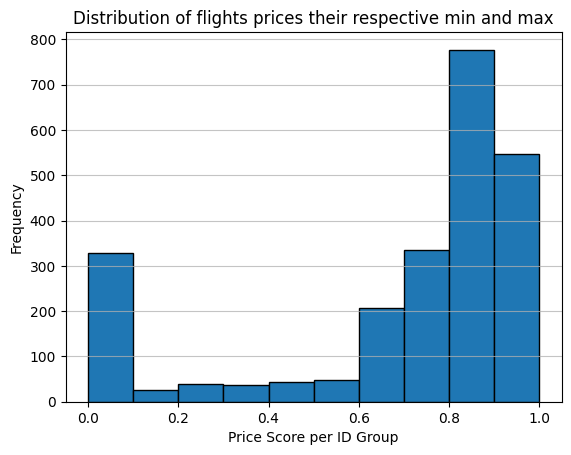

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_reduced is your DataFrame
# Plotting the histogram
df_reduced['rel_price_score_FlightID'].plot.hist(bins=10, range=(0, 1), edgecolor='black')

plt.title('Distribution of flights prices their respective min and max')
plt.xlabel('Price Score per ID Group')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)  # Optional: Add grid lines for better readability

plt.show()

** Average indicates that the average maximum relative difference increases with Price**

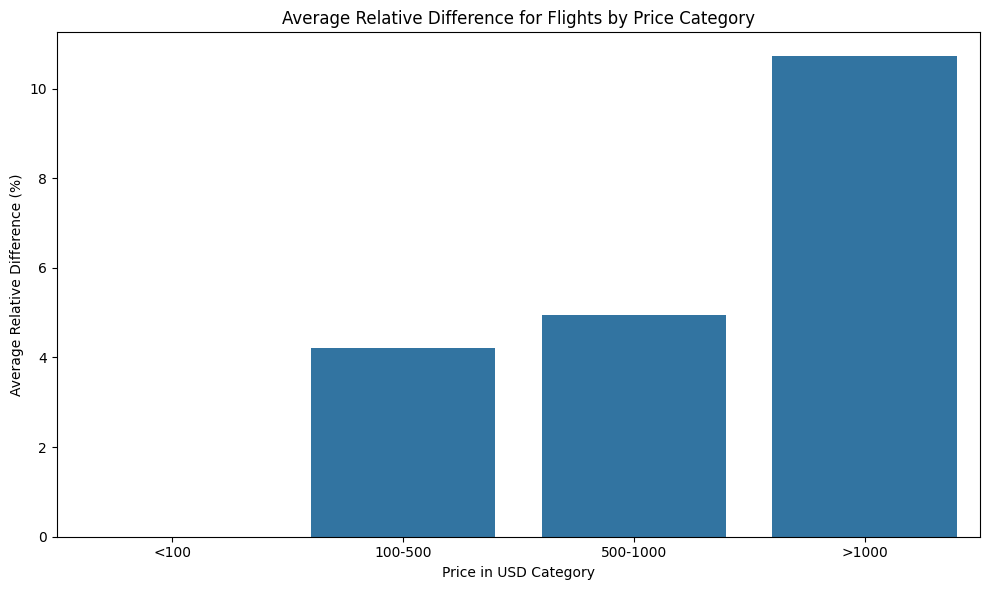

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and labels for 'Price_in_USD'
bins = [0, 100, 500, 1000, float('inf')]
labels = ['<100', '100-500', '500-1000', '>1000']

# Bin 'Price_in_USD' into the defined categories
df_reduced['Price_Category'] = pd.cut(df_reduced['Price_in_USD'], bins=bins, labels=labels)

# Group by the new 'Price_Category' and calculate the mean 'rel_diff' for each category
avg_rel_diff_by_price_cat = df_reduced.groupby('Price_Category', observed=True)['max_rel_price_diff_FlightID'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_price_cat, x='Price_Category', y='max_rel_price_diff_FlightID')
plt.title('Average Relative Difference for Flights by Price Category')
plt.xlabel('Price in USD Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()


** Median doesnt show this effect **

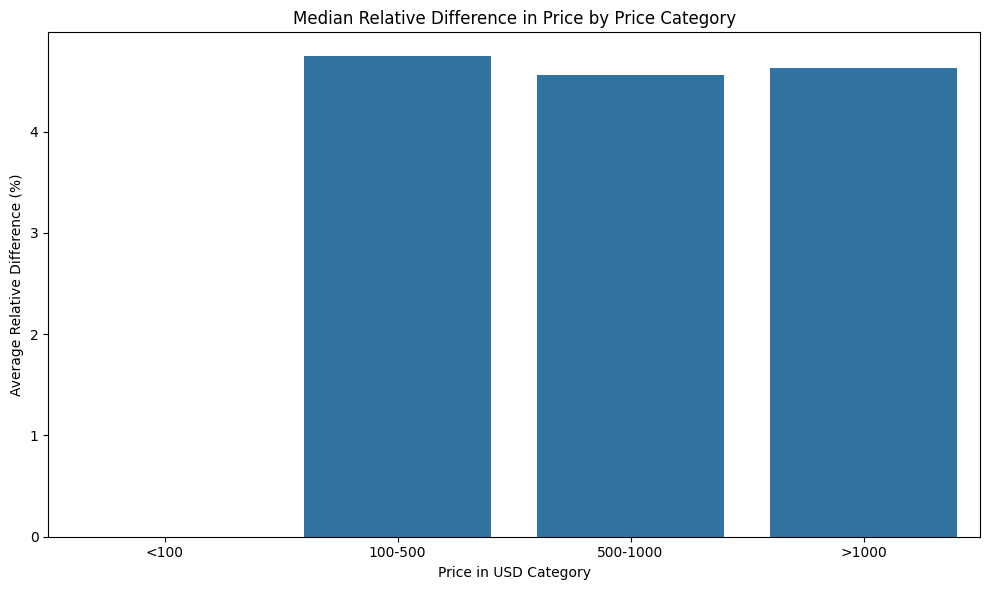

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and labels for 'Price_in_USD'
bins = [0, 100, 500, 1000, float('inf')]
labels = ['<100', '100-500', '500-1000', '>1000']

# Bin 'Price_in_USD' into the defined categories
df_reduced['Price_Category'] = pd.cut(df_reduced['Price_in_USD'], bins=bins, labels=labels)

# Group by the new 'Price_Category' and calculate the mean 'rel_diff' for each category
avg_rel_diff_by_price_cat = df_reduced.groupby('Price_Category', observed=True)['max_rel_price_diff_FlightID'].median().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_price_cat, x='Price_Category', y='max_rel_price_diff_FlightID')
plt.title('Median Relative Difference in Price by Price Category')
plt.xlabel('Price in USD Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()

**The average price spread grows with commute time**

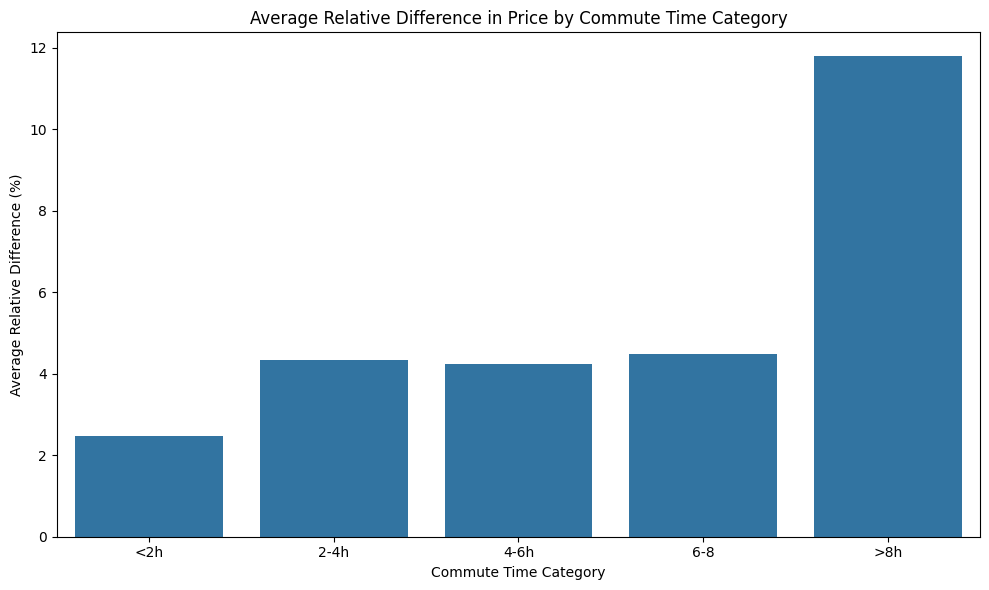

In [56]:
# Adjust bins based on the new categories in minutes
bins = [-float('inf'), 120, 240, 480,750, float('inf')]
labels = ['<2h', '2-4h', '4-6h','6-8' ,'>8h']

# Bin 'commute_time' into categories directly, no need to convert to hours since it's already in minutes
df_reduced['Commute_Time_Category'] = pd.cut(df_reduced['commute_time'], bins=bins, labels=labels)

# Group by the new 'Commute_Time_Category' and calculate the mean 'max_rel_diff_perIDGroup' for each category
avg_rel_diff_by_commute_cat = df_reduced.groupby('Commute_Time_Category', observed = True)['max_rel_price_diff_FlightID'].mean().reset_index()

# Plotting the average relative difference by commute time category
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_commute_cat, x='Commute_Time_Category', y='max_rel_price_diff_FlightID')
plt.title('Average Relative Difference in Price by Commute Time Category')
plt.xlabel('Commute Time Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()


**Most Airlines seem to have an average price-spread in between of 3.5 and 4.5**

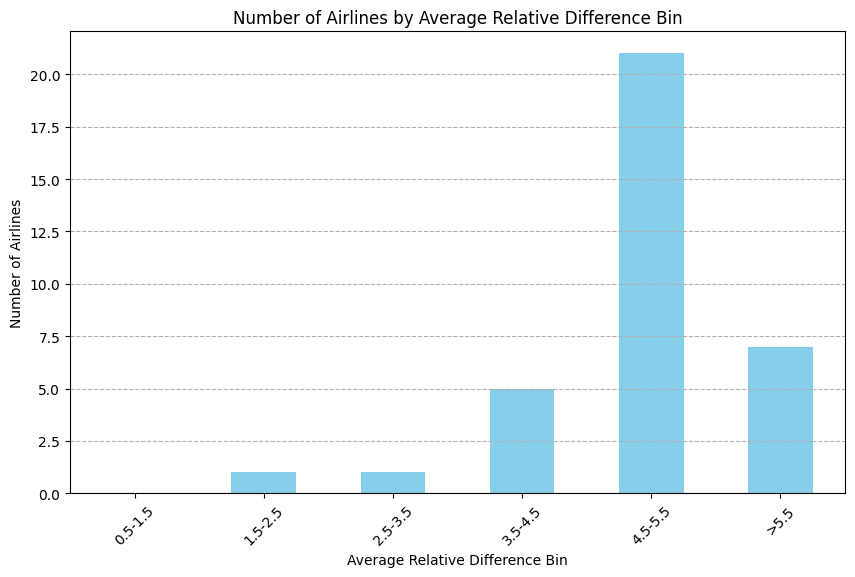

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the conditional mean of 'rel_diff' for each airline
avg_rel_diff_per_airline = df_reduced.groupby('airline_code', observed=True)['max_rel_price_diff_FlightID'].mean().reset_index()

# Define bins and labels for the categorized means
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, float('inf')]
labels = [ '0.5-1.5', '1.5-2.5', '2.5-3.5', '3.5-4.5', '4.5-5.5', '>5.5']

# Step 2: Categorize these averages into the specified bins
avg_rel_diff_per_airline['avg_rel_diff_bin'] = pd.cut(avg_rel_diff_per_airline['max_rel_price_diff_FlightID'], bins=bins, labels=labels)

# Step 3: Count how many airlines fall into each bin
airlines_per_bin = avg_rel_diff_per_airline['avg_rel_diff_bin'].value_counts().sort_index()

# Plotting the result
airlines_per_bin.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of Airlines by Average Relative Difference Bin')
plt.xlabel('Average Relative Difference Bin')
plt.ylabel('Number of Airlines')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


**Which airlines change their prices based on location**

In [58]:
# Group airlines by their average 'rel_diff' bin
grouped_airlines = avg_rel_diff_per_airline.groupby('avg_rel_diff_bin')['airline_code'].apply(list)

# Convert to a DataFrame for a nicer display, if desired
grouped_airlines_df = grouped_airlines.reset_index().rename(columns={'airline_code': 'Airlines'})


# Display the DataFrame
print(grouped_airlines_df)


  avg_rel_diff_bin                                           Airlines
0          0.5-1.5                                                 []
1          1.5-2.5                                               [XE]
2          2.5-3.5                                               [DL]
3          3.5-4.5                               [AS, LA, LH, TK, TP]
4          4.5-5.5  [AA, AF, AM, AV, AZ, BA, BR, CM, CX, F9, JL, L...
5             >5.5                    [AC, EK, IB, KL, QR, UA, multi]


In [59]:
avg_rel_diff_per_airline

airline_code  max_rel_price_diff_FlightID avg_rel_diff_bin
0            AA                     4.921051          4.5-5.5
1            AC                    64.734473             >5.5
2            AF                     4.999096          4.5-5.5
3            AM                     4.637533          4.5-5.5
4            AS                     3.502412          3.5-4.5
5            AV                     4.542922          4.5-5.5
6            AZ                     4.604290          4.5-5.5
7            BA                     4.566377          4.5-5.5
8            BR                     4.643414          4.5-5.5
9            CM                     4.625982          4.5-5.5
10           CX                     4.653511          4.5-5.5
11           DL                     3.478145          2.5-3.5
12           EK                     7.537154             >5.5
13           F9                     4.552570          4.5-5.5
14           IB                     7.243590             >5.5
15           JL                     4.631234          4.5-5.5
16           KL                     6.613759             >5.5
17           LA                     4.473724          3.5-4.5
18           LH                     3.750482          3.5-4.5
19           LX                     4.881966          4.5-5.5
20           MS                     4.632597          4.5-5.5
21           NH                     4.641611          4.5-5.5
22           OZ                     4.633441          4.5-5.5
23           QR                    18.059858             >5.5
24           SQ                     4.536269          4.5-5.5
25           TG                     4.614432          4.5-5.5
26           TK                     3.514450          3.5-4.5
27           TP                     4.454339          3.5-4.5
28           UA                    28.032247             >5.5
29           UX                     4.719420          4.5-5.5
30           VY                     5.083260          4.5-5.5
31           W4                     4.638016          4.5-5.5
32           WK                     4.766589          4.5-5.5
33           XE                     1.517413          1.5-2.5
34        multi                     5.612499             >5.5

Which countries are the cheapest?

In [60]:
import xgboost

In [61]:
cheap_df = df_reduced[(df_reduced['min_price_FlightID'] == df_reduced['Price_in_USD'] )]

# Get the distribution of 'Detected_Country' in the filtered DataFrame
country_distribution = cheap_df['Detected_Country'].value_counts()

# Display the distribution
print(country_distribution)


Detected_Country
Shqipëri          245
Brasil             32
日本                 11
United Kingdom      1
Name: count, dtype: int64


**Which countries are more expensive**

In [62]:

expensive_df = df_reduced[(df_reduced['max_price_FlightID'] == df_reduced['Price_in_USD'])]

# Get the distribution of 'Detected_Country' in the filtered DataFrame
country_distribution = expensive_df['Detected_Country'].value_counts()

# Display the distribution
print(country_distribution)


Detected_Country
Australia             192
Schweiz                75
Palestine              13
Vereinigte Staaten      9
Name: count, dtype: int64


# Statistical Testing

In [63]:
from scipy.stats import f_oneway

# Assuming 'flight_data' is your DataFrame containing flight information
# 'Price' is the column containing flight prices, and 'Country' is the column containing country information

# Extract prices for each country
prices_by_country = [group['Price_in_USD'].values for name, group in df_reduced.groupby('Flight_ID')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*prices_by_country)

# Interpret the results
alpha = 0.05  # Significance level
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There are statistically significant differences in mean flight prices among different countries.")
else:
    print("There are no statistically significant differences in mean flight prices among different countries.")


ANOVA results:
F-statistic: 700.3148669078242
p-value: 0.0
There are statistically significant differences in mean flight prices among different countries.


In [64]:
from scipy.stats import f_oneway

# Assuming 'df' is your DataFrame containing flight information
# 'Price_in_USD' is the column containing flight prices, and 'Assigned_Country' is the column containing country information

# Extract prices for each country
prices_by_country = [group['Price_in_USD'].values for name, group in df_reduced.groupby('Flight_ID')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*prices_by_country)

# Interpret the results
alpha = 0.05  # Significance level
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There are statistically significant differences in mean flight prices among different countries for the same flight route.")
else:
    print("There are no statistically significant differences in mean flight prices among different countries for the same flight route.")


ANOVA results:
F-statistic: 700.3148669078242
p-value: 0.0
There are statistically significant differences in mean flight prices among different countries for the same flight route.


In [65]:
from scipy.stats import ttest_rel

# Assuming 'df' is your DataFrame containing flight information
# 'Price_in_USD' is the column containing flight prices, and 'Flight_ID' is the column containing flight identifiers

# Group the data by Flight_ID and calculate the maximum and minimum prices for each group
max_prices = df_reduced.groupby('Flight_ID')['Price_in_USD'].max()
min_prices = df_reduced.groupby('Flight_ID')['Price_in_USD'].min()

# Perform paired samples t-test
t_statistic, p_value = ttest_rel(max_prices, min_prices)

# Interpret the results
alpha = 0.05  # Significance level
print("Paired samples t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There is a statistically significant difference between the maximum and minimum prices of each Flight_ID.")
else:
    print("There is no statistically significant difference between the maximum and minimum prices of each Flight_ID.")


Paired samples t-test results:
t-statistic: 5.184409370380557
p-value: 4.087471333332363e-07
There is a statistically significant difference between the maximum and minimum prices of each Flight_ID.


# Modelling

Predicting average price spread  

In [283]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb  # corrected import statement
from sklearn.metrics import mean_squared_error  # corrected import for regression metrics

# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route','days_until_departure','Detected_Country','Detected_Currency']], drop_first=True)
y = df_reduced['average_savings_for_Journey_route_in_Detected_Country']  # remove get_dummies for y

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)  # corrected variable name for fitting

# Predict and evaluate
y_pred = xgb_model.predict(X_test)  # corrected variable name for prediction
# Evaluation metrics for regression
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


Mean Squared Error: 8.612005042647305e-05


In [284]:
df_test = pd.read_csv("../data/4.processed_data/Query1503_results_processed.csv")
X_test = pd.get_dummies(df_test[['Journey_route', 'days_until_departure', 'Detected_Country','Detected_Currency']], drop_first=True)
y_test = df_test['average_savings_for_Journey_route_in_Detected_Country']

In [285]:
# Add missing dummy variables to X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0  # Add the missing column and fill with 0

# Remove any extra columns in X_test that are not in X_train
X_test = X_test[X_train.columns]
dtest = xgb.DMatrix(data=X_test)

In [286]:
# Assume X_train_columns is the list of columns in the training dataset after preprocessing
X_train_columns = X.columns.tolist()

# Encode the test dataset
X_test_encoded = pd.get_dummies(X_test)

# Add missing columns to the test set and fill them with 0
for column in X_train_columns:
    if column not in X_test_encoded.columns:
        X_test_encoded[column] = 0

# Ensure the order of columns in the test set matches the training set
X_test_encoded = X_test_encoded[X_train_columns]

# Now you can convert this aligned test set into DMatrix and proceed with prediction
dtest = xgb.DMatrix(data=X_test_encoded)

In [280]:
y_pred_test = xgb_model.predict(X_test_encoded)


In [282]:
# Calculate Mean Absolute Error (MAE) on the test set
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Mean Absolute Error on Test Set: {mae_test}")

Mean Absolute Error on Test Set: 5.219738961007761


Predicting Cheapest Country Location 

In [254]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max_price_FlightID',
       'min_price_FlightID', 'max_price_diff_FlightID',
       'max_rel_price_diff_FlightID', 'abs_diff_to_min_price_FlightID',
       'rel_diff_to_min_price_FlightID', 'rel_price_score_FlightID',
       'max_price_JourneyID', 'min_price_JourneyID', 'max_abs_diff_JourneyID',
       'max_rel_diff_Journey', 'abs_diff_to_min_price_JourneyID',
       'rel_diff_to_min_price_JourneyID', 'rel_price_score_JourneyID',
       'max_journey_same_country', 'min_journey_same_country',
       'max_abs_diff_perIDG

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route','days_until_departure','Detected_Country']], drop_first=True)
y = pd.get_dummies(df_reduced['Cheapest_Location_Flight'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=71)

# Create and fit the model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # Adjust model parameters as needed
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
# Evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
# ROC-AUC can be computed for binary classification, and for multi-class, strategies like One-vs-Rest need to be applied.
# Depending on your y structure, you might need to adapt the ROC AUC computation.
# print(f"ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')}")


Accuracy: 0.9881422924901185
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.99      1.00      0.99       221
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         9

   micro avg       0.99      0.99      0.99       253
   macro avg       0.75      0.74      0.74       253
weighted avg       0.98      0.99      0.98       253
 samples avg       0.99      0.99      0.99       253



In [72]:
df_reduced.Cheapest_Location_Flight.value_counts()

Cheapest_Location_Flight
Shqipëri          2167
Brasil             259
日本                  90
United Kingdom      10
Name: count, dtype: int64

# Random Experiments / Notepad

In [79]:
import pandas as pd
import xgboost as xgb


# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route','days_until_departure','Detected_Country']], drop_first=True)
y = df_reduced['average_savings_for_Journey_route_in_Detected_Country']


# Convert the dataset into a DMatrix, which is a data structure unique to XGBoost
# DMatrix is optimized for both memory efficiency and training speed.
data_dmatrix = xgb.DMatrix(data=X, label=y)

# Define parameters for the XGB model
params = {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.08, 'max_depth': 7, 'subsample': 0.8,'objective': 'reg:squarederror'}

# Define cross-validation parameters
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50, early_stopping_rounds=10, metrics="mae", as_pandas=True, seed=42)

# Print final CV score
print(cv_results.tail(1))



    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
49        0.525527       0.016199       0.608331      0.199126


In [237]:
df_reduced.departure_date

0      2024-06-26 07:15:00
1      2024-06-26 07:15:00
2      2024-06-26 07:15:00
3      2024-06-26 07:15:00
4      2024-06-26 07:15:00
5      2024-06-26 07:15:00
6      2024-06-26 07:15:00
7      2024-06-26 07:15:00
8      2024-06-26 11:50:00
9      2024-06-26 11:50:00
10     2024-06-26 11:50:00
11     2024-06-26 11:50:00
12     2024-06-26 11:50:00
13     2024-06-26 11:50:00
14     2024-06-26 11:50:00
15     2024-06-26 11:50:00
16     2024-06-26 13:05:00
17     2024-06-26 13:05:00
18     2024-06-26 13:05:00
19     2024-06-26 13:05:00
20     2024-06-26 13:05:00
21     2024-06-26 13:05:00
22     2024-06-26 13:05:00
23     2024-06-26 13:05:00
24     2024-06-26 09:05:00
25     2024-06-26 09:05:00
26     2024-06-26 09:05:00
27     2024-06-26 09:05:00
28     2024-06-26 09:05:00
29     2024-06-26 09:05:00
30     2024-06-26 09:05:00
31     2024-06-26 09:05:00
32     2024-06-26 10:07:00
33     2024-06-26 10:07:00
34     2024-06-26 10:07:00
35     2024-06-26 10:07:00
36     2024-06-26 10:07:00
3

In [178]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['de', 'days_until_departure', 'Detected_Country']], drop_first=True)
y = df_reduced['average_savings_for_Journey_route_in_Detected_Country']

# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the grid of hyperparameters to search
param_grid = {
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0.0, 0.1],
    'learning_rate': np.arange(0.0001,0.2,0.0001),
    'max_depth': [6, 7, 8],
    'subsample': [0.7, 0.8, 0.9]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)

Fitting 10 folds for each of 21528 candidates, totalling 215280 fits


Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.184, 'max_depth': 7, 'subsample': 0.9}
Best score found:  0.49249280132975165


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route', 'days_until_departure', 'Detected_Country']], drop_first=True)
y = df_reduced['average_savings_for_Journey_route_in_Detected_Country']

# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the grid of hyperparameters to search
param_grid = {
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0.0, 0.1],
    'learning_rate': np.arange(0.0001,0.3,0.0001),
    'max_depth': [1,2,3,4,5,6, 7, 8],
    'subsample': [0.7, 0.8, 0.9]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)

In [193]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route', 'days_until_departure', 'Detected_Country','Detected_Currency']], drop_first=True)
y = df_reduced['average_savings_for_Journey_route_in_Detected_Country']

# Create Random Forest model
rf_model = RandomForestRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100,150,175,200,220,240,300,700],  # Number of trees in the forest
    'max_features': ['log2', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 1,2,3,4,5,6,10, 20],  # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)


Fitting 10 folds for each of 3240 candidates, totalling 32400 fits


/Users/aghauss/Library/Caches/pypoetry/virtualenvs/playwright-trial-uIq0qThi-py3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/aghauss/Library/Caches/pypoetry/virtualenvs/playwright-trial-uIq0qThi-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
16200 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6128 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aghauss/Library/Caches/pypoetry/virtualenvs/playwright-trial-uIq0q

Best parameters found:  {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best score found:  0.5052342767667031


In [229]:
import joblib
# Save the best parameters
best_params = grid_search.best_params_
joblib.dump(best_params, 'best_params_rf.pkl')

# Create a new Random Forest model with the best parameters
best_rf_model = RandomForestRegressor(**best_params)

# Fit the model with the entire dataset
best_rf_model.fit(X, y)

# Save the trained model
joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

In [230]:
# Load the trained model
loaded_model = joblib.load('best_rf_model.pkl')


y_test = df_test['average_savings_for_Journey_route_in_Detected_Country']  # Actual target values

# Use the loaded model to make predictions
predicted_values = loaded_model.predict(X_test_encoded)

# Assess the predictions
mae = mean_absolute_error(y_test, predicted_values)
print("Mean Absolute Error (MAE):", mae)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Detected_Currency_AUD
- Detected_Currency_BDT
- Detected_Currency_BRL
- Detected_Currency_CHF
- Detected_Currency_EUR
- ...


In [179]:
# Create a new model with the best parameters
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=grid_search.best_params_['colsample_bytree'],
    gamma=grid_search.best_params_['gamma'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    subsample=grid_search.best_params_['subsample']
)

In [180]:
best_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.184, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
"""
from sklearn.model_selection import KFold, GridSearchCV

# Define the number of folds for cross-validation
n_folds = 10  # Same as Model 1

# Define the cross-validation strategy using KFold
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
from xgboost import XGBRegressor  # Import XGBRegressor for regression tasks

# Ensure 'model' is an instance of XGBRegressor
model = XGBRegressor(random_state=42)
param_grid = {
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0.2, 0.3, 0.4],
    'learning_rate': [0.1,0.01,0.02,0.03,0.04,0.05,0.06,0.07, 0.08, 0.09],
    'max_depth': [3,4,5,6, 7, 8],
    'subsample': [0.7, 0.8, 0.9]
}
# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route','days_until_departure','Detected_Country']], drop_first=True)
y = df_reduced['average_savings_for_Journey_route_in_Detected_Country']


# Update Model 2 to use GridSearchCV with the specified cross-validation strategy
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', 
                           n_jobs=-1, cv=cv, verbose=2)
grid_search.fit(X, y)
"""

"\nfrom sklearn.model_selection import KFold, GridSearchCV\n\n# Define the number of folds for cross-validation\nn_folds = 10  # Same as Model 1\n\n# Define the cross-validation strategy using KFold\ncv = KFold(n_splits=n_folds, shuffle=True, random_state=42)\nfrom xgboost import XGBRegressor  # Import XGBRegressor for regression tasks\n\n# Ensure 'model' is an instance of XGBRegressor\nmodel = XGBRegressor(random_state=42)\nparam_grid = {\n    'colsample_bytree': [0.7, 0.8],\n    'gamma': [0.2, 0.3, 0.4],\n    'learning_rate': [0.1,0.01,0.02,0.03,0.04,0.05,0.06,0.07, 0.08, 0.09],\n    'max_depth': [3,4,5,6, 7, 8],\n    'subsample': [0.7, 0.8, 0.9]\n}\n# Define independent and dependent variables\nX = pd.get_dummies(df_reduced[['Journey_route','days_until_departure','Detected_Country']], drop_first=True)\ny = df_reduced['average_savings_for_Journey_route_in_Detected_Country']\n\n\n# Update Model 2 to use GridSearchCV with the specified cross-validation strategy\ngrid_search = GridSearc

In [77]:
"""
# Best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Best MAE score obtained
best_mae = -grid_search.best_score_

print("Best parameters found:", best_params)
print("Best MAE score:", best_mae)

# Additional information about the best estimator
best_estimator = grid_search.best_estimator_
print("\nBest estimator:")
print(best_estimator)
"""

'\n# Best parameters found by GridSearchCV\nbest_params = grid_search.best_params_\n\n# Best MAE score obtained\nbest_mae = -grid_search.best_score_\n\nprint("Best parameters found:", best_params)\nprint("Best MAE score:", best_mae)\n\n# Additional information about the best estimator\nbest_estimator = grid_search.best_estimator_\nprint("\nBest estimator:")\nprint(best_estimator)\n'

# Testing the model on new data^

In [181]:
df_test = pd.read_csv("../data/4.processed_data/Query1503_results_processed.csv")
X_test = pd.get_dummies(df_test[['Journey_route', 'days_until_departure', 'Detected_Country']], drop_first=True)

In [182]:
# Add missing dummy variables to X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0  # Add the missing column and fill with 0

# Remove any extra columns in X_test that are not in X_train
X_test = X_test[X_train.columns]
dtest = xgb.DMatrix(data=X_test)

In [186]:
# Assume X_train_columns is the list of columns in the training dataset after preprocessing
X_train_columns = X.columns.tolist()

# Encode the test dataset
X_test_encoded = pd.get_dummies(X_test)

# Add missing columns to the test set and fill them with 0
for column in X_train_columns:
    if column not in X_test_encoded.columns:
        X_test_encoded[column] = 0

# Ensure the order of columns in the test set matches the training set
X_test_encoded = X_test_encoded[X_train_columns]

# Now you can convert this aligned test set into DMatrix and proceed with prediction
dtest = xgb.DMatrix(data=X_test_encoded)

In [188]:
# Assuming `best_model` is your trained model and `X_test` is your prepared test set
predictions = best_model.predict(X_test_encoded)

In [190]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df_test.average_savings_for_Journey_route_in_Detected_Country, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 8.612377262238658


# Look at new data

In [205]:
df_test.average_savings_for_Journey_route_in_Detected_Country.describe()

count    1499.000000
mean        5.370842
std         3.577205
min         0.000000
25%         3.453752
50%         4.848053
75%         6.316946
max        23.112097
Name: average_savings_for_Journey_route_in_Detected_Country, dtype: float64

In [206]:
df_reduced.average_savings_for_Journey_route_in_Detected_Country.describe()

count    2526.000000
mean        3.948621
std         9.824383
min         0.000000
25%         3.076153
50%         3.798121
75%         4.270509
max       169.333250
Name: average_savings_for_Journey_route_in_Detected_Country, dtype: float64

In [208]:
df_test.query_date.value_counts()

query_date
2024-03-15    1499
Name: count, dtype: int64

In [217]:
X_test_encoded = pd.DataFrame(X_test_encoded)

In [219]:
correlation_values = df_test['average_savings_for_Journey_route_in_Detected_Country'].corrwith(X_test_encoded)

AttributeError: 'Series' object has no attribute 'corrwith'

In [224]:
df_test_encoded = pd.get_dummies(df_test)

In [227]:
import pandas as pd

# Assuming df_test is the DataFrame and X_test_encoded is a DataFrame containing encoded features

# Calculate the correlation of each column in X_test_encoded with the specified Series in df_test
correlation_values = {}

# Loop over all columns in X_test_encoded
for column in df_test_encoded.columns:
    correlation_values[column] = df_test_encoded['average_savings_for_Journey_route_in_Detected_Country'].corr(df_test_encoded[column])

# Convert the dictionary to a pandas Series
correlation_series = pd.Series(correlation_values)

# Display the correlation values
correlation_series.sort_values(ascending=False)


average_savings_for_Journey_route_in_Detected_Country    1.000000
rel_price_diff_loc_to_glob_Journey_min                   0.671702
departure_airport_code_DFW                               0.619644
destination_airport_code_EWR                             0.619644
Journey_route_DFW-EWR                                    0.619644
                                                           ...   
destination_airport_code_JFK                            -0.356762
Detected_Language_Shqip                                 -0.411391
Detected_Country_Shqipëri                               -0.411391
Detected_Currency_ALL                                   -0.411391
query_date_2024-03-15                                         NaN
Length: 1011, dtype: float64

In [244]:
df_reduced.average_savings_for_JourneyID_in_Detected_Country.describe()

count    2526.000000
mean        3.948621
std         9.920563
min         0.000000
25%         3.075852
50%         3.795673
75%         4.211850
max       169.333250
Name: average_savings_for_JourneyID_in_Detected_Country, dtype: float64

In [245]:
df_test.average_savings_for_Journey_route_in_Detected_Country.describe()

count    1499.000000
mean        5.370842
std         3.577205
min         0.000000
25%         3.453752
50%         4.848053
75%         6.316946
max        23.112097
Name: average_savings_for_Journey_route_in_Detected_Country, dtype: float64

In [239]:
X_org_encoded = pd.get_dummies(X)

In [242]:
import pandas as pd

# Assuming df_test is the DataFrame and X_test_encoded is a DataFrame containing encoded features

# Calculate the correlation of each column in X_test_encoded with the specified Series in df_test
correlation_values = {}

# Loop over all columns in X_test_encoded
for column in X_org_encoded.columns:
    correlation_values[column] = df_reduced['average_savings_for_Journey_route_in_Detected_Country'].corr(X_org_encoded[column])

# Convert the dictionary to a pandas Series
correlation_series = pd.Series(correlation_values)

# Display the correlation values
correlation_series.sort_values(ascending=False)

Journey_route_LAX-LIS                  0.470217
Detected_Currency_AUD                  0.126757
Detected_Country_United Kingdom        0.122152
Detected_Currency_GBP                  0.122152
Journey_route_MAN-CPT                  0.087201
Journey_route_PHX-CGH                  0.033958
Detected_Currency_USD                  0.006933
Detected_Country_Vereinigte Staaten    0.006933
Detected_Country_Schweiz               0.006563
Detected_Currency_CHF                  0.006563
Detected_Country_Palestine             0.000806
Detected_Currency_JOD                  0.000806
Journey_route_FCO-MAD                 -0.000814
Journey_route_ZAG-LIM                 -0.002865
Journey_route_CMN-HKG                 -0.003514
Journey_route_EDI-ZRH                 -0.003799
Journey_route_LUX-DUB                 -0.003906
Journey_route_SCL-MEX                 -0.004613
Detected_Currency_BDT                 -0.004699
Detected_Country_বাংলাদেশ             -0.004699
Journey_route_LIM-DEL                 -0

In [232]:
import pandas as pd

# Assuming df_test is the DataFrame and X_test_encoded is a DataFrame containing encoded features

# Calculate the correlation of each column in X_test_encoded with the specified Series in df_test
correlation_values = {}

# Loop over all columns in X_test_encoded
for column in df_test_encoded.columns:
    correlation_values[column] = df_test_encoded['average_savings_for_Journey_route_in_Detected_Country'].corr(df_test_encoded[column])

# Convert the dictionary to a pandas Series
correlation_series = pd.Series(correlation_values)

# Display the correlation values
correlation_series.sort_values(ascending=False)

average_savings_for_Journey_route_in_Detected_Country    1.000000
rel_price_diff_loc_to_glob_Journey_min                   0.671702
departure_airport_code_DFW                               0.619644
destination_airport_code_EWR                             0.619644
Journey_route_DFW-EWR                                    0.619644
                                                           ...   
destination_airport_code_JFK                            -0.356762
Detected_Language_Shqip                                 -0.411391
Detected_Country_Shqipëri                               -0.411391
Detected_Currency_ALL                                   -0.411391
query_date_2024-03-15                                         NaN
Length: 1011, dtype: float64

In [236]:
# Display the full sorted Series
pd.set_option('display.max_rows', None)  # This sets the maximum number of rows to display to None, showing all rows
correlation_series.sort_values(ascending=False)

average_savings_for_Journey_route_in_Detected_Country                                                                                                                                                                                                                 1.000000
rel_price_diff_loc_to_glob_Journey_min                                                                                                                                                                                                                                0.671702
departure_airport_code_DFW                                                                                                                                                                                                                                            0.619644
destination_airport_code_EWR                                                                                                                                                               

In [211]:
X.average_saving   

days_until_departure  Journey_route_CAN-MUC  Journey_route_CGK-JFK  \
0                      132                  False                  False   
1                      132                  False                  False   
2                      132                  False                  False   
3                      132                  False                  False   
4                      132                  False                  False   
...                    ...                    ...                    ...   
2521                   207                  False                  False   
2522                   207                  False                  False   
2523                   207                  False                  False   
2524                   207                  False                  False   
2525                   207                  False                  False   

      Journey_route_CLT-CUN  Journey_route_CMN-HKG  Journey_route_CUN-IAD  \
0                      True                  False                  False   
1                      True                  False                  False   
2                      True                  False                  False   
3                      True                  False                  False   
4                      True                  False                  False   
...                     ...                    ...                    ...   
2521                  False                  False                  False   
2522                  False                  False                  False   
2523                  False                  False                  False   
2524                  False                  False                  False   
2525                  False                  False                  False   

      Journey_route_DFW-BWI  Journey_route_DFW-EWR  Journey_route_DFW-SEA  \
0                     False                  False                  False   
1                     False                  False                  False   
2                     False                  False                  False   
3                     False                  False                  False   
4                     False                  False                  False   
...                     ...                    ...                    ...   
2521                  False                  False                  False   
2522                  False                  False                  False   
2523                  False                  False                  False   
2524                  False                  False                  False   
2525                  False                  False                  False   

      Journey_route_EDI-ZRH  ...  Detected_Country_Indonesia  \
0                     False  ...                       False   
1                     False  ...                        True   
2                     False  ...                       False   
3                     False  ...                       False   
4                     False  ...                       False   
...                     ...  ...                         ...   
2521                  False  ...                       False   
2522                  False  ...                       False   
2523                  False  ...                       False   
2524                  False  ...                        True   
2525                  False  ...                       False   

      Detected_Country_Palestine  Detected_Country_Polska  \
0                          False                    False   
1                          False                    False   
2                          False                    False   
3                          False                    False   
4                          False                    False   
...                          ...                      ...   
2521                       False               

# Combining the data

In [288]:
df_reduced.head()

airline_code departure_airport_code destination_airport_code  ticket_price  \
0           AA                    CLT                      CUN           383   
1           AA                    CLT                      CUN       6464034   
2           AA                    CLT                      CUN         12863   
3           AA                    CLT                      CUN           364   
4           AA                    CLT                      CUN           328   

       departure_date        arrival_date First_flight first_flight_code  \
0 2024-06-26 07:15:00 2024-06-26 09:10:00      CLT-CUN             AA881   
1 2024-06-26 07:15:00 2024-06-26 09:10:00      CLT-CUN             AA881   
2 2024-06-26 07:15:00 2024-06-26 09:10:00      CLT-CUN             AA881   
3 2024-06-26 07:15:00 2024-06-26 09:10:00      CLT-CUN             AA881   
4 2024-06-26 07:15:00 2024-06-26 09:10:00      CLT-CUN             AA881   

  last_flight_code        Detected_Language  ...  \
0            AA881                  Deutsch  ...   
1            AA881                Indonesia  ...   
2            AA881                   Türkçe  ...   
3            AA881                  Deutsch  ...   
4            AA881  English (United States)  ...   

  price_diff_loc_to_glob_Journey_min rel_price_diff_loc_to_glob_Journey_min  \
0                          16.280000                               4.097040   
1                          16.338176                               4.111681   
2                          14.256000                               3.587679   
3                          17.600000                               4.429233   
4                          15.920000                               4.006443   

  Cheapest_Location_Journey  Cheapest_Location_Flight  \
0                  Shqipëri                  Shqipëri   
1                  Shqipëri                  Shqipëri   
2                  Shqipëri                  Shqipëri   
3                  Shqipëri                  Shqipëri   
4                  Shqipëri                  Shqipëri   

   average_savings_for_JourneyID_in_Detected_Country  \
0                                           4.006011   
1                                           4.111472   
2                                           3.586726   
3                                           4.516763   
4                                           3.902242   

  average_savings_for_Journey_route_in_Detected_Country  \
0                                           4.008192      
1                                           4.111395      
2                                           3.586338      
3                                           4.517712      
4                                           3.894831      

   Mode_Cheapest_Location_Journey  Price_Category Commute_Time_Category  \
0                        Shqipëri         100-500                   <2h   
1                        Shqipëri         100-500                   <2h   
2                        Shqipëri         100-500                   <2h   
3                        Shqipëri         100-500                   <2h   
4                        Shqipëri         100-500                   <2h   

  rel_price_diff_loc_to_glob_Journey_min_rounded  
0                                            4.1  
1                                            4.1  
2                                            3.6  
3                                            4.4  
4                                            4.0  

[5 rows x 50 columns]

In [291]:
combined_df = pd.concat([df_reduced, df_test], ignore_index=True)

In [301]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(combined_df[['Journey_route','days_until_departure','Detected_Country','Detected_Currency']])
y = combined_df['average_savings_for_Journey_route_in_Detected_Country']

# Now proceed with the splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Now you have train_df, validation_df, and test_df


In [307]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the model
model = XGBRegressor(objective='reg:squarederror', eval_metric='mae')

# Define the grid of parameters to search
param_grid = {
    'max_depth': [3, 4, 5,6,7],
    'eta': np.arange(0.001,0.3,0.001),
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best MAE score: {-grid_search.best_score_}")

Fitting 10 folds for each of 13455 candidates, totalling 134550 fits
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001, max_depth=3, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.001,

In [303]:
# Using the best parameters from your grid search output
best_params = {'colsample_bytree': 0.9, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.8}

# Create a new model with the best parameters
optimal_model = XGBRegressor(objective='reg:squarederror', eval_metric='mae', **best_params)

# Fit the model on your training data
optimal_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric='mae',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [304]:
predictions = optimal_model.predict(X_test)

In [305]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.2932257246313492
